In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
from eo_flood_ops.model_utils import GroundTruthMeasurement
from eo_flood_ops.thresholding_model import ThresholdingModel
from eo_flood_ops.general_utils import tif_to_clipped_masked_array, tif_to_clipped_array, find_closest_valid

class MyGroundTruthMeasurement(GroundTruthMeasurement):
  pass

import xarray as xr  # noqa: E402

In [2]:
images_dir = R"p:\11211461-010--eo-flood-ops\Sava\classified_events"
aoi_dir = R"p:\11211461-010--eo-flood-ops\Sava\AOI_obs_based"
waterlevels_fn = R"p:\11211461-010--eo-flood-ops\Sava\water_levels\Sava_Bosna_gauges_H_20190101_20250430.csv"
dem_fn = R"p:\11211461-010--eo-flood-ops\Sava\DEMs\bosna_FABDEM.tif"

In [3]:
df_water = pd.read_csv(waterlevels_fn, skiprows=[1])
df_water.rename(columns={df_water.columns[0]: "datetime"}, inplace=True)
df_water["datetime"] = pd.to_datetime(df_water["datetime"])

results_per_aoi = {}

# Loop over AOI files
for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]
    if aoi_name == "Modrica":
        continue
    print(f"Processing AOI: {aoi_name}")
    print("*" * 45)
    # Store image-water level tuples
    image_water_levels = []
    
    # Loop over images
    for image_name in os.listdir(images_dir):
        if not image_name.endswith(".tif"):
            continue
        

        datetime_str = image_name.split("_")[1].replace(".tif", "") 
        dt = datetime.strptime(datetime_str, "%Y%m%dT%H%M%S")
        dt = pd.Timestamp(dt)
        dt_gmt1 = dt + pd.Timedelta(hours=1)  # Convert to GMT+1

        closest_time, value = find_closest_valid(df_water, dt_gmt1, aoi_name)
        
        if closest_time is not None:
            print(f"Image: {image_name}")
            print(f"Image timestamp (GMT+1): {dt_gmt1}")
            print("Closest valid timestamp:", closest_time)
            print(f"{aoi_name} value:", value)
            print("=" * 45)
            image_water_levels.append((image_name, value))
        else:
            print(f"No valid {aoi_name} values found in dataset for image {image_name}.")

    if not image_water_levels:
        print(f"No images found for AOI: {aoi_name}")
        continue

    # print some spacing to improve readability
    print("\n" * 1)

    # Sort by water level ascending
    image_water_levels.sort(key=lambda x: x[1])
    
    # Store results
    results_per_aoi[aoi_name] = image_water_levels

Processing AOI: Raspotocje
*********************************************
Image: Bosna_20190204T164100.tif
Image timestamp (GMT+1): 2019-02-04 17:41:00
Closest valid timestamp: 2019-02-04 18:00:00
Raspotocje value: 2.57
Image: Bosna_20211107T045415.tif
Image timestamp (GMT+1): 2021-11-07 05:54:15
Closest valid timestamp: 2021-11-07 06:00:00
Raspotocje value: 2.79


Processing AOI: Kakanj nB
*********************************************
Image: Bosna_20190204T164100.tif
Image timestamp (GMT+1): 2019-02-04 17:41:00
Closest valid timestamp: 2019-02-04 18:00:00
Kakanj nB value: 2.89
Image: Bosna_20211107T045415.tif
Image timestamp (GMT+1): 2021-11-07 05:54:15
Closest valid timestamp: 2021-11-07 06:00:00
Kakanj nB value: 3.38


Processing AOI: Ljubnici
*********************************************
Image: Bosna_20190204T164100.tif
Image timestamp (GMT+1): 2019-02-04 17:41:00
Closest valid timestamp: 2019-02-04 18:00:00
Ljubnici value: 2.03
Image: Bosna_20211107T045415.tif
Image timestamp (GMT+

In [4]:
# Prepare GROUND TRUTH for each AOI

# Dictionary to store GROUND_TRUTH per AOI
GROUND_TRUTH_per_aoi = {}

for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]
    if aoi_name == "Modrica":  # skip for now
        continue
    
    aoi_fn = os.path.join(aoi_dir, aoi_file)
    
    # Make sure we have results for this AOI
    if aoi_name not in results_per_aoi:
        print(f"No images found for AOI: {aoi_name}")
        continue
    
    GROUND_TRUTH = []
    
    for image_name, water_level in results_per_aoi[aoi_name]:
        image_path = os.path.join(images_dir, image_name)
        
        masked_array, transforms, crs = tif_to_clipped_masked_array(
            image_path,
            aoi_fn,
        )
        
        GROUND_TRUTH.append(MyGroundTruthMeasurement(
            ground_truth=masked_array,
            gauge_measurement=water_level
        ))
    
    # Store per AOI
    GROUND_TRUTH_per_aoi[aoi_name] = GROUND_TRUTH

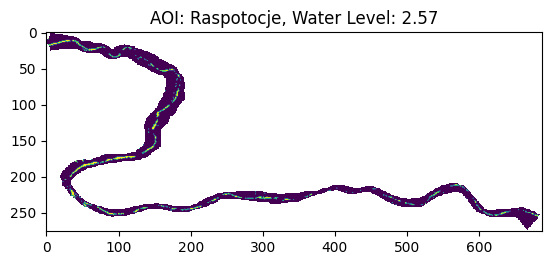

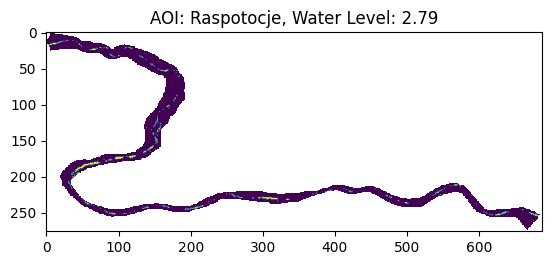

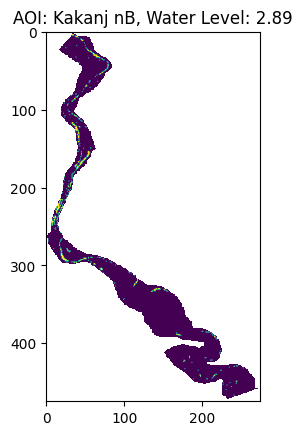

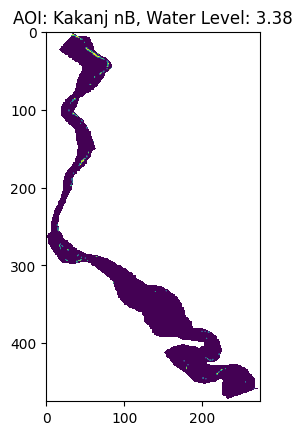

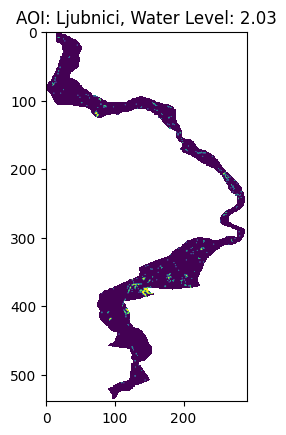

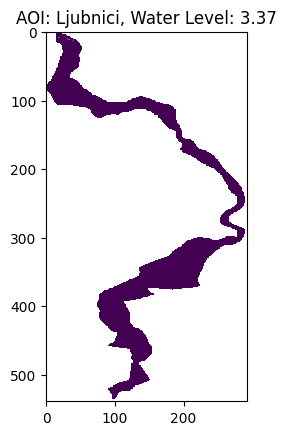

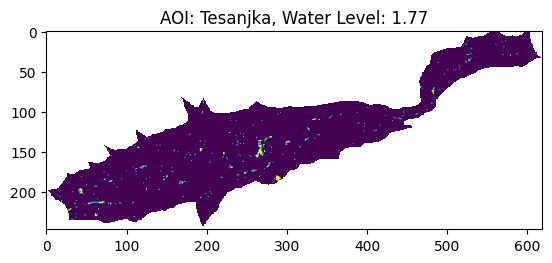

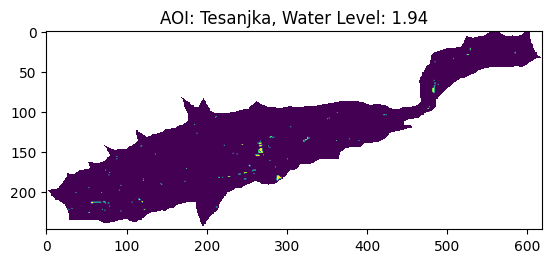

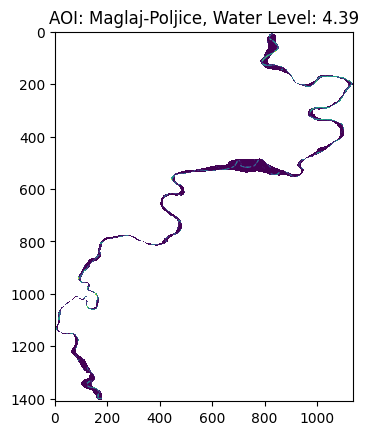

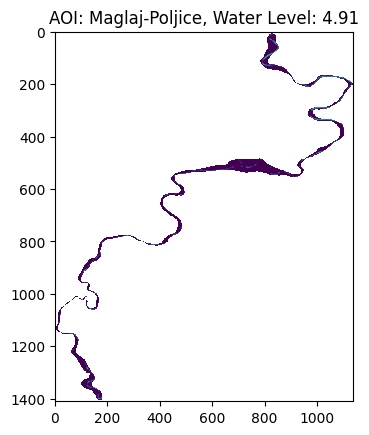

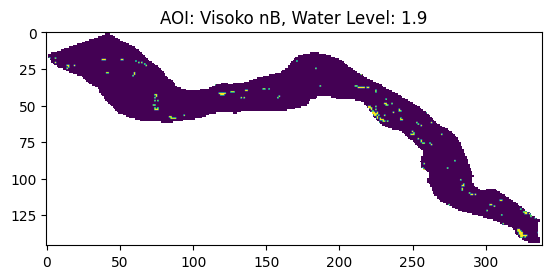

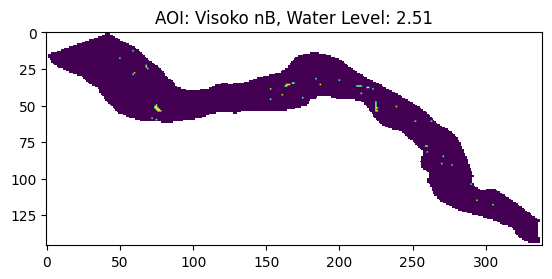

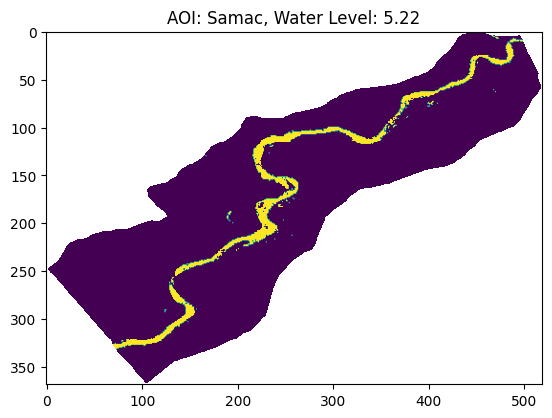

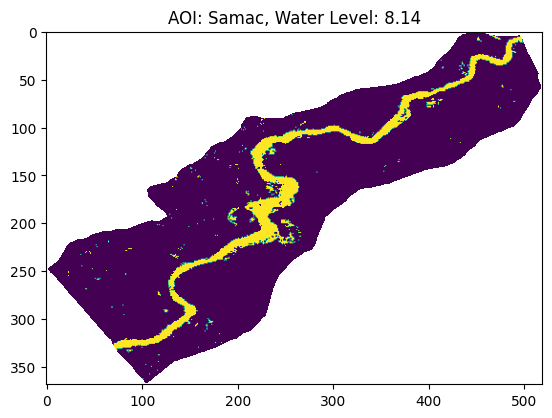

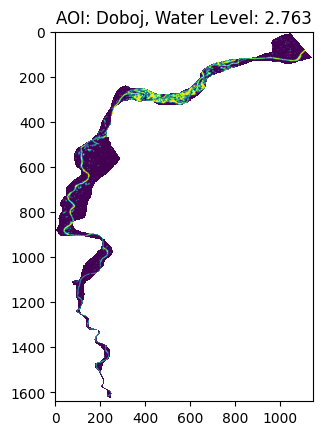

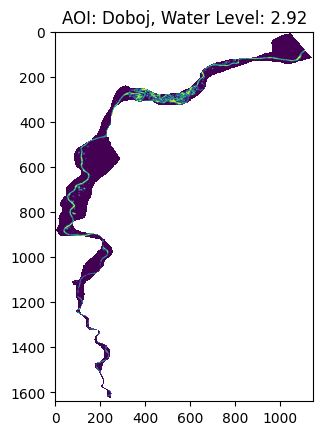

In [5]:
for aoi in results_per_aoi:
    for gt in GROUND_TRUTH_per_aoi[aoi]:
        plt.imshow(gt.ground_truth)
        plt.title(f"AOI: {aoi}, Water Level: {gt.gauge_measurement}")
        plt.show()

### Thresholding 

In [6]:
# MIN_RATIOS = [0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20]
MIN_RATIOS = [0.1, 1]

trained_models_tm= {}

for aoi_name, GROUND_TRUTH in GROUND_TRUTH_per_aoi.items():
    print("\n" + "="*60)
    print(f"Starting training for AOI: {aoi_name}")
    print(f"Number of ground truth images: {len(GROUND_TRUTH)}")
    print(f"Using minimum ratios: {MIN_RATIOS}")
    
    tm = ThresholdingModel()
    
    tm.train(
        minumum_ratios=MIN_RATIOS,
        ground_truth=GROUND_TRUTH
    )
    
    trained_models_tm[aoi_name] = tm
    print(f"Finished training for AOI: {aoi_name}")
    print("="*60)



Starting training for AOI: Raspotocje
Number of ground truth images: 2
Using minimum ratios: [0.1, 1]
For min_ratio=0.1 we get f1=0.8394552208006603
For min_ratio=1 we get f1=0.8394552208006603
chosen min_ratio 1
Finished training for AOI: Raspotocje

Starting training for AOI: Kakanj nB
Number of ground truth images: 2
Using minimum ratios: [0.1, 1]
For min_ratio=0.1 we get f1=0.7561683599419448
For min_ratio=1 we get f1=0.7561683599419448
chosen min_ratio 1
Finished training for AOI: Kakanj nB

Starting training for AOI: Ljubnici
Number of ground truth images: 2
Using minimum ratios: [0.1, 1]
For min_ratio=0.1 we get f1=0.6693266832917705
For min_ratio=1 we get f1=0.6693266832917705
chosen min_ratio 1
Finished training for AOI: Ljubnici

Starting training for AOI: Tesanjka
Number of ground truth images: 2
Using minimum ratios: [0.1, 1]
For min_ratio=0.1 we get f1=0.775055679287305
For min_ratio=1 we get f1=0.775055679287305
chosen min_ratio 1
Finished training for AOI: Tesanjka

Sta

In [7]:
trained_models_tm

{'Raspotocje': <inundation_model_utils.ThresholdingModel at 0x2e7a27b4650>,
 'Kakanj nB': <inundation_model_utils.ThresholdingModel at 0x2e79a15a1d0>,
 'Ljubnici': <inundation_model_utils.ThresholdingModel at 0x2e7a27959d0>,
 'Tesanjka': <inundation_model_utils.ThresholdingModel at 0x2e7a2762690>,
 'Maglaj-Poljice': <inundation_model_utils.ThresholdingModel at 0x2e7a282ab50>,
 'Visoko nB': <inundation_model_utils.ThresholdingModel at 0x2e7a2760b90>,
 'Samac': <inundation_model_utils.ThresholdingModel at 0x2e7a2768b10>,
 'Doboj': <inundation_model_utils.ThresholdingModel at 0x2e79a12d490>}

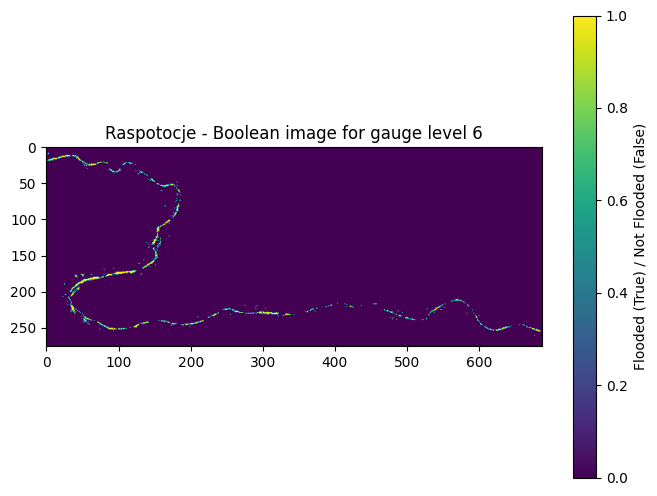

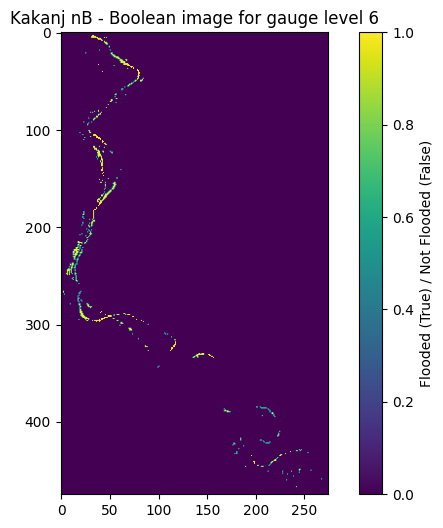

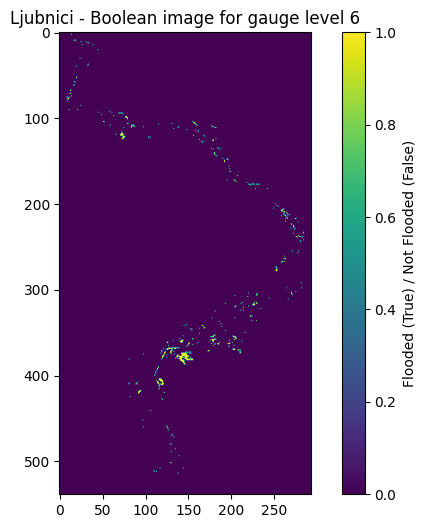

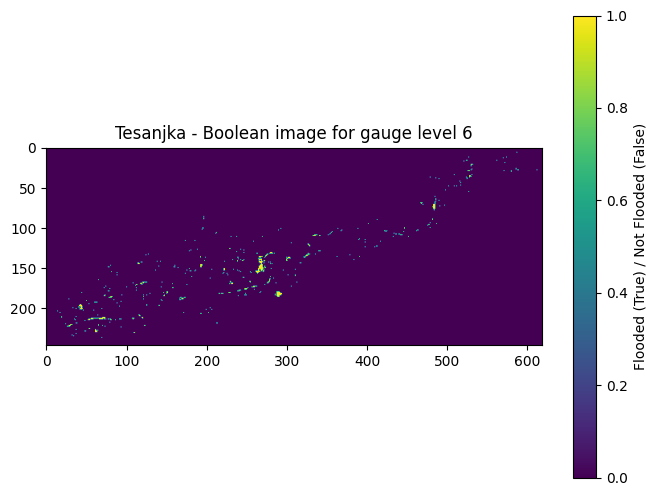

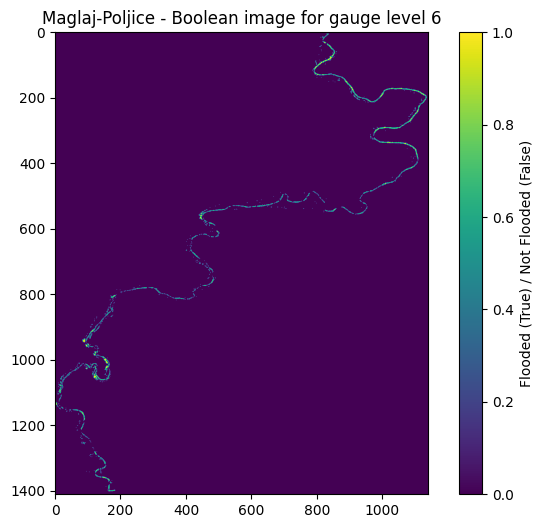

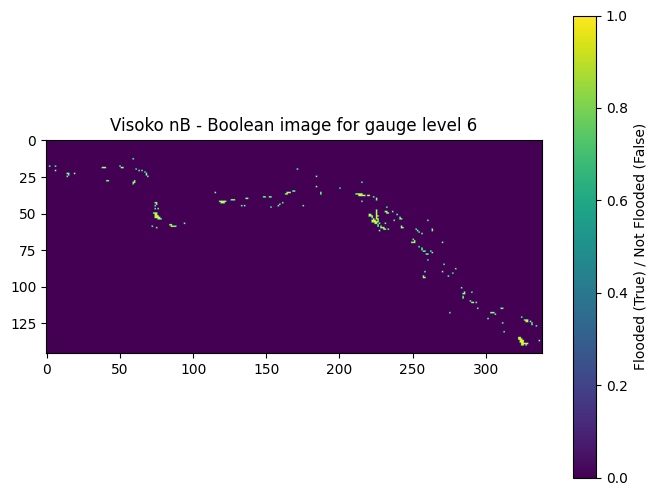

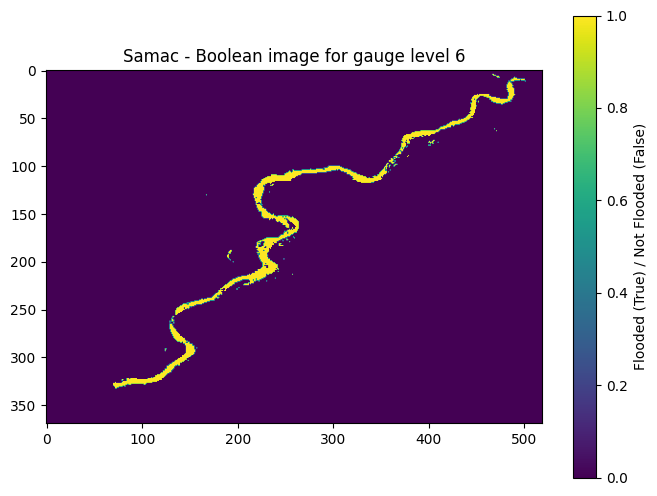

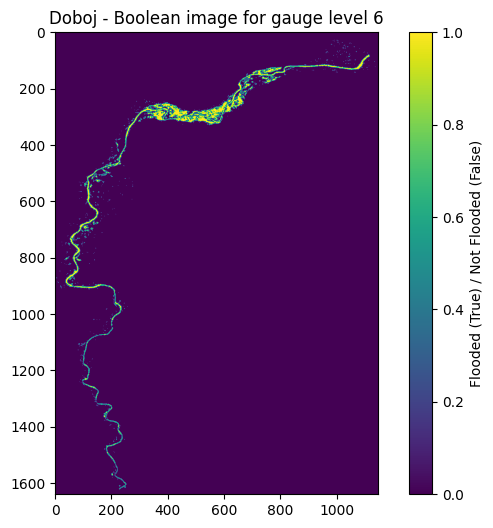

In [8]:
# Example gauge levels to test
gauge_levels = [6]

# Loop over all AOIs and trained models
for aoi_name, tm in trained_models_tm.items():
    for gauge_level in gauge_levels:
        plt.figure(figsize=(8, 6))
        plt.title(f'{aoi_name} - Boolean image for gauge level {gauge_level}')
        plt.imshow(tm.infer(gauge_level))  # Boolean images are usually better in gray
        plt.colorbar(label='Flooded (True) / Not Flooded (False)')
        plt.show()

### Manifold 

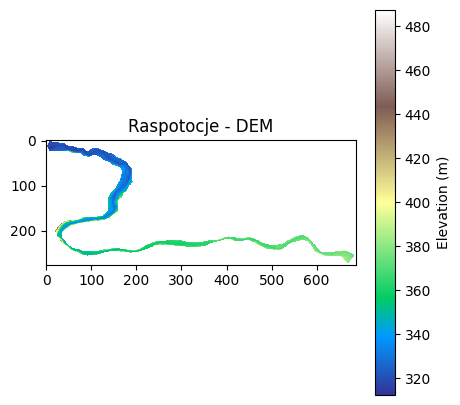

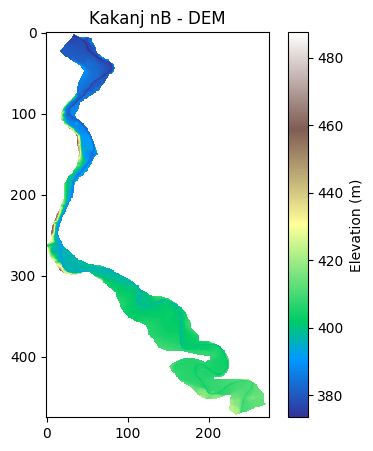

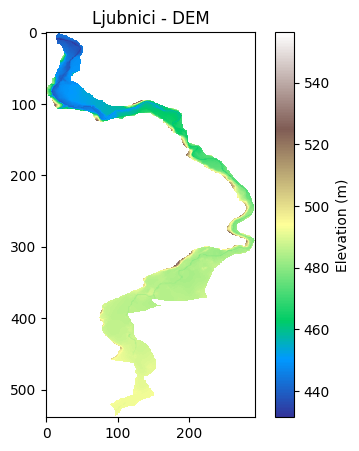

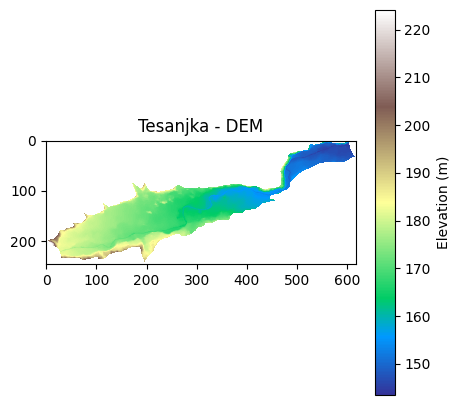

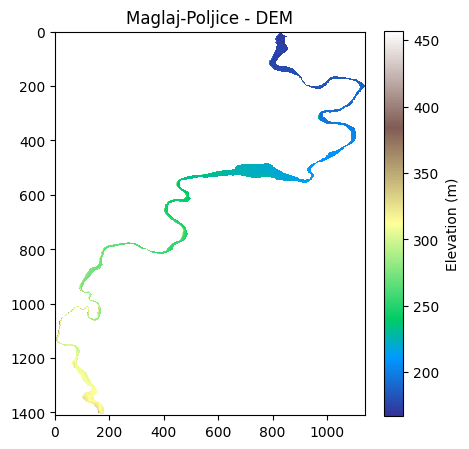

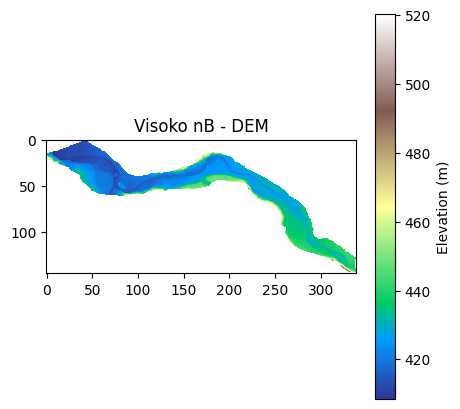

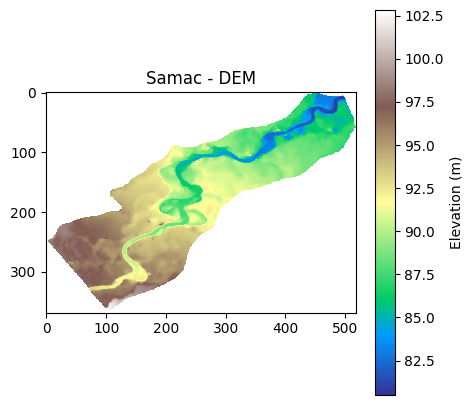

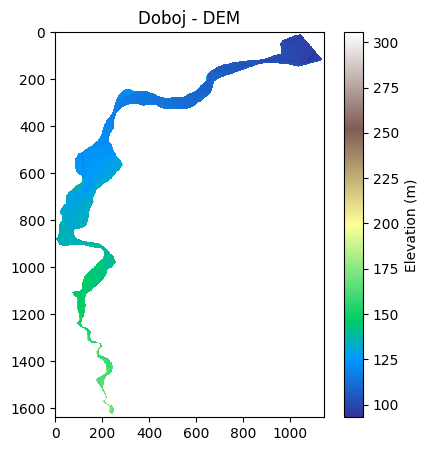

In [9]:
DEM_per_aoi = {}

for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    if aoi_file.split('_')[1].split('.')[0] == "Modrica":  # skip for now
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]
    aoi_fn = os.path.join(aoi_dir, aoi_file)
    
    # Clip DEM for this AOI
    DEM, dem_transform, dem_crs = tif_to_clipped_array(dem_fn, aoi_fn)
    
    # Store in a dictionary
    DEM_per_aoi[aoi_name] = {
        'DEM': DEM,
        'transform': dem_transform,
        'crs': dem_crs
    }
    
    # Optional: quick visualization
    plt.figure(figsize=(5, 5))
    plt.title(f'{aoi_name} - DEM')
    plt.imshow(DEM, cmap='terrain')
    plt.colorbar(label='Elevation (m)')
    plt.show()
    

In [11]:
from inundation_model_utils import flood_extent_to_depth_solve, LaplaceDepthSolverConfig, ManifoldModel

AOI: Kakanj nB
Kakanj nB


ValueError: need at least one array to concatenate

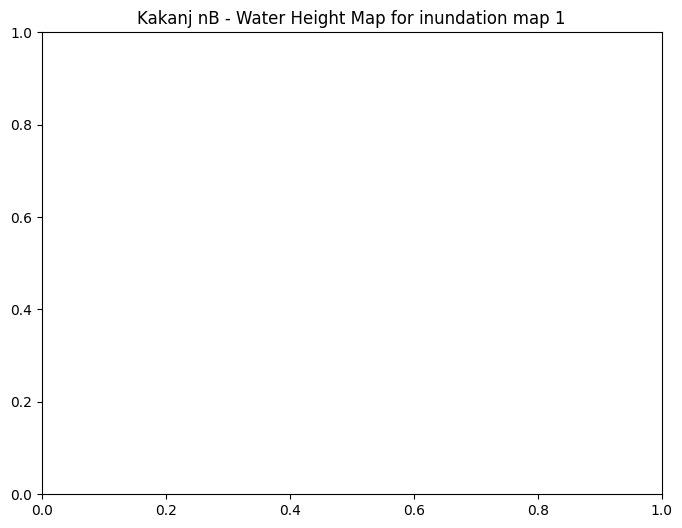

In [ ]:
#@title Plot flood extent to depth output
for aoi_name, GROUND_TRUTH in GROUND_TRUTH_per_aoi.items():
    if aoi_name == "Raspotocje":
        continue
    print(f"AOI: {aoi_name}")
    plt.figure(figsize=(8, 6))
    plt.title(f'{aoi_name} - Water Height Map for inundation map 1')
    print(aoi_name)
    height_raster = flood_extent_to_depth_solve(
        inundation_map=GROUND_TRUTH[0].ground_truth, 
        dem=DEM_per_aoi[aoi_name]['DEM'], 
        scale=30, 
        laplace_config=LaplaceDepthSolverConfig(
            down_scale_factor=32, 
            solve_iterations_factor=3.,
            force_coeff=0.1,
            drop_iterations=2,
            drop_coeff=0.1),
        force_tolerance=1, 
        force_local_region_width=5)
    
    plt.imshow(height_raster)
    plt.colorbar(label='[m]')
    plt.show()

In [15]:
trained_models_mm = {}
# MIN_RATIOS = [0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20]
MIN_RATIOS = [0.1, 1, 2,]
for aoi_name, GROUND_TRUTH in GROUND_TRUTH_per_aoi.items():
    print("\n" + "="*60)
    print(f"Starting training for AOI: {aoi_name}")
    print(f"Number of ground truth images: {len(GROUND_TRUTH)}")
    print(f"Using minimum ratios: {MIN_RATIOS}")

    # Get DEM for this AOI
    DEM = DEM_per_aoi[aoi_name]['DEM']

    # Create the model
    mm = ManifoldModel(
        dem=DEM,
        scale=30,
        laplace_config=LaplaceDepthSolverConfig(
            down_scale_factor=8,
            solve_iterations_factor=3.,
            force_coeff=0.9,
            drop_iterations=1,
            drop_coeff=0.00003
        ),
        force_tolerance=1,
        force_local_region_width=5,
        flood_agree_threshold=0.1
    )

    

    mm.train(
        minumum_ratios=MIN_RATIOS,
        ground_truth=GROUND_TRUTH
    )

    trained_models_mm[aoi_name] = mm
    print(f"Finished training for AOI: {aoi_name}")
    print("="*60)



Starting training for AOI: Raspotocje
Number of ground truth images: 2
Using minimum ratios: [0.1, 1, 2]
Training an inner thresholding model used for flood-fill.
For min_ratio=0.1 we get f1=0.8394552208006603
For min_ratio=1 we get f1=0.8394552208006603
For min_ratio=2 we get f1=0.7635258358662614
chosen min_ratio 1
Running flood extent to depth on ground truth examples..
Running flood extent to depth algorithm for image at gauge_level 2.57


ValueError: need at least one array to concatenate

In [17]:
trained_models_mm

{'Tesanjka': <inundation_model_utils.ManifoldModel at 0x19e9608f790>,
 'Kosova': <inundation_model_utils.ManifoldModel at 0x19e96056250>,
 'Samac': <inundation_model_utils.ManifoldModel at 0x19e9608fa90>}

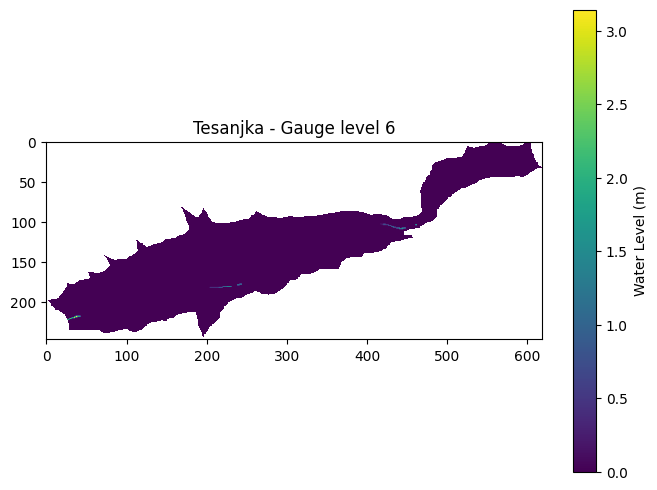

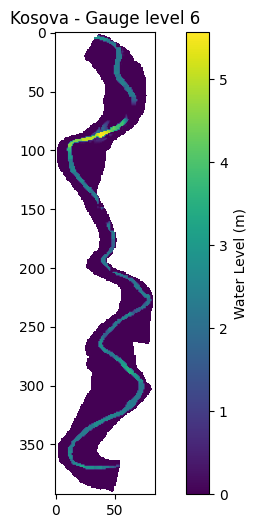

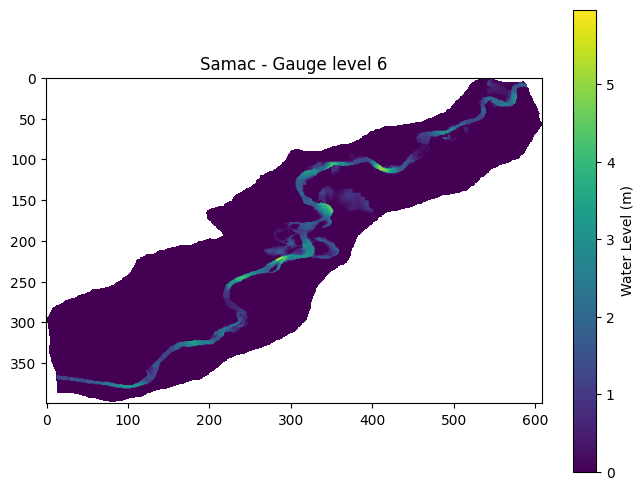

In [18]:
# Example gauge levels to test
gauge_levels = [6]

# Loop over all AOIs and trained models
for aoi_name, tm in trained_models_mm.items():
    for gauge_level in gauge_levels:
        plt.figure(figsize=(8, 6))
        plt.title(f'{aoi_name} - Gauge level {gauge_level}')
        plt.imshow(tm.infer(gauge_level))  # Boolean images are usually better in gray
        plt.colorbar(label='Water Level (m)')
        plt.show()

In [19]:
# function to generate a CF-compliant xarray Dataset of wet/dry masks or water depths for a time series of water levels 
# this includes a lat/lon grid and a water_level coordinate along time

def generate_wet_dry_timeseries_ds(water_levels, timestamps, tm, transform, crs):
    """
    Generate a CF-compliant xarray Dataset of wet/dry masks (boolean) or
    water depths (float) for a time series of water levels using a trained model.
    Includes water_level as a coordinate.

    Args:
        water_levels (list or array): Water levels to infer wet/dry masks or depths.
        timestamps (list or pd.DatetimeIndex): Corresponding timestamps.
        tm: Trained model with method tm.infer(level).
            - Returns boolean arrays for thresholding models.
            - Returns masked float arrays for manifold models.
        transform (Affine): Rasterio affine transform of the raster.
        crs (rasterio.crs.CRS): CRS of the raster (must be EPSG:4326).

    Returns:
        xr.Dataset: CF-compliant Dataset with dimensions (time, lat, lon)
    """
    def array_to_da(array, is_bool):
        """Convert boolean/float/masked array to xarray.DataArray with lat/lon."""
        if not isinstance(array, np.ma.MaskedArray):
            masked = np.ma.masked_array(array)
        else:
            masked = array

        nrows, ncols = masked.shape
        xs = np.arange(ncols)
        ys = np.arange(nrows)
        lon, _ = rasterio.transform.xy(transform, 0, xs, offset="center")
        _, lat = rasterio.transform.xy(transform, ys, 0, offset="center")
        lon = np.array(lon)
        lat = np.array(lat)

        # Ensure latitude is sorted ascending
        if lat[0] > lat[-1]:
            lat = lat[::-1]
            masked = masked[::-1, :]

        # Convert data
        if is_bool:
            data = masked.astype(np.float32)  # True/False → 1.0/0.0
        else:
            data = masked.filled(np.nan).astype(np.float32)

        da = xr.DataArray(
            data,
            dims=("lat", "lon"),
            coords={"lat": lat, "lon": lon},
        )

        if is_bool:
            da.attrs.update({"long_name": "wet_dry_mask", "units": "1"})
        else:
            da.attrs.update({"long_name": "water_depth", "units": "m"})

        da.attrs["grid_mapping"] = "spatial_ref"
        return da

    # Detect model type (boolean vs float)
    test_out = tm.infer(water_levels[0])
    is_bool = np.issubdtype(test_out.dtype, np.bool_)

    arrays = []
    for lvl in water_levels:
        arr = tm.infer(lvl)
        da = array_to_da(arr, is_bool)
        arrays.append(da)

    # Stack along time
    varname = "wet_dry" if is_bool else "water_depth"
    ts_da = xr.concat(arrays, dim=pd.Index(timestamps, name="time"))

    # Build Dataset
    ds = xr.Dataset({varname: ts_da})

    # Add water_level as coordinate along time
    ds = ds.assign_coords({"water_level": ("time", water_levels)})
    ds["water_level"].attrs.update({"long_name": "water_level", "units": "m"})

    # Add CF-compliant spatial_ref
    ds["spatial_ref"] = xr.DataArray(
        0,
        attrs={
            "spatial_ref": crs.to_wkt(),
            "grid_mapping_name": "latitude_longitude",
            "longitude_of_prime_meridian": 0.0,
            "semi_major_axis": 6378137.0,
            "inverse_flattening": 298.257223563,
        },
    )
    ds[varname].attrs["grid_mapping"] = "spatial_ref"

    # Coordinate metadata
    ds["lat"].attrs.update({"standard_name": "latitude", "units": "degrees_north"})
    ds["lon"].attrs.update({"standard_name": "longitude", "units": "degrees_east"})

    return ds

In [20]:
gauge_levels = [1, 6, 7.5, 3.2, 10]
timestamps = pd.date_range("2020-01-01", periods=len(gauge_levels), freq="7D")

ds_per_aoi = {}  # dict to store datasets

for aoi_name, trained_model in trained_models_mm.items():    
    transform = DEM_per_aoi[aoi_name]['transform']
    crs = DEM_per_aoi[aoi_name]['crs']

    # Generate the Dataset for this AOI
    ds_man = generate_wet_dry_timeseries_ds(
        water_levels=gauge_levels,
        timestamps=timestamps,
        tm=trained_model,
        transform=transform,
        crs=crs
    )

    # Store in the dictionary
    ds_per_aoi[aoi_name] = ds_man

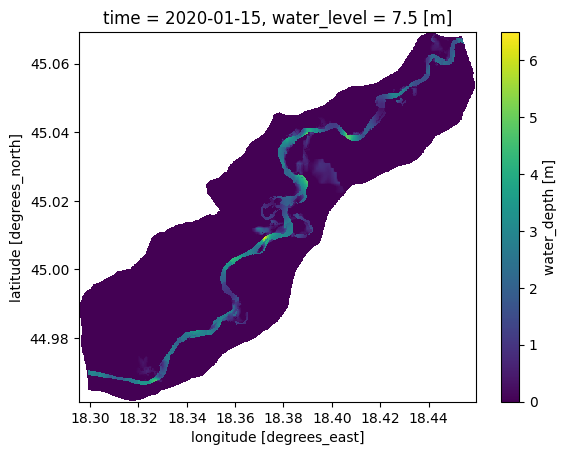

In [21]:
ds_per_aoi["Samac"]["water_depth"].sel(time="2020-01-15").plot()